In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

In [6]:
W = np.random.normal(0, 1, (1000,))
X = W + np.random.normal(0, 1, (1000,)) 
Z = np.random.normal(1, 0, (1000,)) 
Y = X + Z + W + np.random.normal(0, 1, (1000,))

### Q1: Suppose that a process can be modeled via linear regression: 
Which is closest to the correlation of $X$ with the error term in the equati

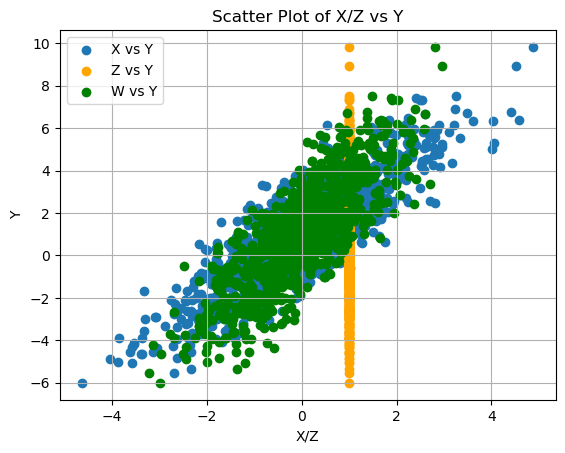

In [18]:
plt.scatter(X, Y, label='X vs Y')
plt.scatter(Z, Y, label='Z vs Y', color='orange')
plt.scatter(W, Y, label='W vs Y', color='green')
plt.xlabel('X/Z')
plt.ylabel('Y')
plt.title('Scatter Plot of X/Z vs Y')
plt.legend()
plt.grid()
plt.show()

In [21]:
df_1 = pd.DataFrame({'X': X, 'Z': Z, 'W': W, 'Y': Y})
results = sm.OLS.from_formula('Y ~ X + Z + W', data=df_1).fit()

# extract the residuals
residuals = results.resid

# compute the correlation between X and the residuals
corr_X_resid = np.corrcoef(df_1['X'], residuals)[0, 1]
# — or equally df_1['X'].corr(residuals)

print(f"corr(X, residuals) = {corr_X_resid:.4f}")

corr(X, residuals) = -0.0000


In [4]:
# We can calculate the error term from the equation Y = X + Z + W + error
error_term = Y - X - Z - W

# Calculate correlation between X and the error term
correlation = np.corrcoef(X, error_term)[0, 1]
print(f"Correlation between X and the error term: {correlation}")

Correlation between X and the error term: 0.01735520105770956


In [6]:
# If Y is modeled as Y = a*X + b*Z + error, but the true model is Y = X + Z + W + noise,
# then W (which is correlated with X) becomes part of the error term.
# Since X and W are both standard normals and X = W + noise, X and W are correlated.
# The expected correlation between X and the error term (which includes W) is thus close to the correlation between X and W.

# Calculate the correlation between X and W
corr_X_W = np.corrcoef(X, W)[0, 1]
print(f"Expected correlation between X and the error term: {corr_X_W:.3f}")

Expected correlation between X and the error term: 0.700


In [22]:
df = pd.read_csv('/Users/petershmorhun/Documents/GitHub/summer_semester/experimental_design_and_causality/homework/hw_notebooks/homework_7.1.csv', index_col=0)
df.head()

,X,W,Z,Y
0,1.137055,1.221768,0.327829,1.944532
1,-0.112905,0.465835,0.599650,0.655514
2,2.077755,1.795414,-0.063393,5.934411
3,0.456373,-0.512159,1.177413,-0.188064
4,-1.012402,0.080002,-0.275697,-0.533775


In [10]:
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

# Define tolerance for "close to" constant values of W
tolerance = 0.1

# Filter data for W close to -1, 0, and 1
w_minus1 = df[abs(df['W'] - (-1)) <= tolerance]
w_zero = df[abs(df['W'] - 0) <= tolerance]
w_plus1 = df[abs(df['W'] - 1) <= tolerance]

print(f"Sample sizes:")
print(f"W ≈ -1: {len(w_minus1)} observations")
print(f"W ≈ 0: {len(w_zero)} observations")
print(f"W ≈ 1: {len(w_plus1)} observations")

# Function to run regression and print results
def run_regression(data, w_value):
    if len(data) < 10:  # Need sufficient data points
        print(f"\nW ≈ {w_value}: Insufficient data for regression")
        return None
    
    X_vars = data[['X', 'Z']]
    y = data['Y']
    
    model = LinearRegression()
    model.fit(X_vars, y)
    
    print(f"\nRegression for W ≈ {w_value}:")
    print(f"Coefficient of X: {model.coef_[0]:.4f}")
    print(f"Coefficient of Z: {model.coef_[1]:.4f}")
    print(f"Intercept: {model.intercept_:.4f}")
    print(f"R-squared: {model.score(X_vars, y):.4f}")
    
    return model.coef_[0]  # Return coefficient of X

# Run regressions for each W value
coef_w_minus1 = run_regression(w_minus1, -1)
coef_w_zero = run_regression(w_zero, 0)
coef_w_plus1 = run_regression(w_plus1, 1)

# Compare coefficients
print(f"\nSummary of X coefficients:")
if coef_w_minus1 is not None:
    print(f"W ≈ -1: {coef_w_minus1:.4f}")
if coef_w_zero is not None:
    print(f"W ≈ 0: {coef_w_zero:.4f}")
if coef_w_plus1 is not None:
    print(f"W ≈ 1: {coef_w_plus1:.4f}")

Sample sizes:
W ≈ -1: 488 observations
W ≈ 0: 780 observations
W ≈ 1: 455 observations

Regression for W ≈ -1:
Coefficient of X: 0.8580
Coefficient of Z: -0.5875
Intercept: -1.2175
R-squared: 0.5095

Regression for W ≈ 0:
Coefficient of X: 1.3832
Coefficient of Z: -0.5651
Intercept: 0.0019
R-squared: 0.6972

Regression for W ≈ 1:
Coefficient of X: 1.9581
Coefficient of Z: -0.5682
Intercept: 1.0883
R-squared: 0.8178

Summary of X coefficients:
W ≈ -1: 0.8580
W ≈ 0: 1.3832
W ≈ 1: 1.9581


In [11]:
def make_error(corr_const, num): 
    err = list()
    prev = np.random.normal(0, 1) 
    for n in range(num): 
        prev = corr_const * prev + (1 - corr_const) * np.random.normal(0, 1) 
    err.append(prev)
    return np.array(err) 

In [13]:
# Set up the simulation
np.random.seed(42)  # For reproducibility
n_trials = 1000
n_obs = 100
corr_constants = [0.2, 0.5, 0.8]

results = {}

for corr_const in corr_constants:
    x_coefficients = []
    standard_errors = []
    
    for trial in range(n_trials):
        # Generate correlated errors for X and Y
        error_X = make_error(corr_const, n_obs)
        error_Y = make_error(corr_const, n_obs)
        
        # Generate true X (treatment) with error
        X_true = np.random.normal(0, 1, n_obs)
        X_observed = X_true + error_X
        
        # Generate outcome Y with X effect and error
        # True model: Y = 1.5 + 2.0*X + error_Y
        Y = 1.5 + 2.0 * X_true + error_Y
        
        # Fit linear regression: Y ~ X (with intercept)
        X_design = np.column_stack([np.ones(n_obs), X_observed])  # Add intercept
        
        # Calculate coefficients using normal equation
        coefficients = np.linalg.inv(X_design.T @ X_design) @ X_design.T @ Y
        
        # Calculate standard errors
        residuals = Y - X_design @ coefficients
        mse = np.sum(residuals**2) / (n_obs - 2)  # degrees of freedom
        var_covar_matrix = mse * np.linalg.inv(X_design.T @ X_design)
        se_x = np.sqrt(var_covar_matrix[1, 1])  # Standard error of X coefficient
        
        x_coefficients.append(coefficients[1])  # X coefficient (not intercept)
        standard_errors.append(se_x)
    
    # Store results
    results[corr_const] = {
        'std_dev_estimate': np.std(x_coefficients),
        'mean_standard_error': np.mean(standard_errors),
        'coefficients': x_coefficients
    }

# Display results
print("Results for different correlation constants:")
print("=" * 50)
for corr_const in corr_constants:
    print(f"\nCorrelation constant: {corr_const}")
    print(f"(i) Standard deviation of X coefficient estimates: {results[corr_const]['std_dev_estimate']:.4f}")
    print(f"(ii) Mean of standard error estimates: {results[corr_const]['mean_standard_error']:.4f}")
    print(f"True coefficient: 2.0000")
    print(f"Mean estimated coefficient: {np.mean(results[corr_const]['coefficients']):.4f}")

Results for different correlation constants:

Correlation constant: 0.2
(i) Standard deviation of X coefficient estimates: 0.0000
(ii) Mean of standard error estimates: 0.0000
True coefficient: 2.0000
Mean estimated coefficient: 2.0000

Correlation constant: 0.5
(i) Standard deviation of X coefficient estimates: 0.0000
(ii) Mean of standard error estimates: 0.0000
True coefficient: 2.0000
Mean estimated coefficient: 2.0000

Correlation constant: 0.8
(i) Standard deviation of X coefficient estimates: 0.0000
(ii) Mean of standard error estimates: 0.0000
True coefficient: 2.0000
Mean estimated coefficient: 2.0000


In [14]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Example Usage:
vector_a = np.array([[1, 0, -1]])  # Input needs to be 2D array for sklearn
vector_b = np.array([[-1, -1, 0]])
similarity = cosine_similarity(vector_a, vector_b)
print(f"Cosine Similarity: {similarity}")

Cosine Similarity: [[-0.5]]


In [17]:
arrays = [np.array([2, 2, 4]), np.array([1, 2, 4]), np.array([2, 4, 6]), np.array([1, 0, 0])]

for array in arrays:
    print(cosine_similarity(a.reshape(1, -1), array.reshape(1, -1)))

[[0.98198051]]
[[0.99146013]]
[[1.]]
[[0.26726124]]


In [18]:
# define the point and the candidate p‐values
x, y = 2, 1
ps = [1, 100, 1.5, 2]

# function to compute the Minkowski (Lp) norm
def lp_norm(x, y, p):
    return (abs(x)**p + abs(y)**p)**(1/p)

# compute each distance and see how close it is to x=2
for p in ps:
    d = lp_norm(x, y, p)
    print(f"p={p:<5} →  distance = {d:.6f}   (diff from 2 = {abs(d-2):.6f})")

p=1     →  distance = 3.000000   (diff from 2 = 1.000000)
p=100   →  distance = 2.000000   (diff from 2 = 0.000000)
p=1.5   →  distance = 2.447261   (diff from 2 = 0.447261)
p=2     →  distance = 2.236068   (diff from 2 = 0.236068)


In [27]:
import numpy as np
import statsmodels.api as sm
import pandas as pd

# 1. Define the autocorrelated‐error generator
def make_error(corr_const, num):
    arr = []
    prev = np.random.normal(0, 1)
    for _ in range(num):
        prev = corr_const * prev + (1 - corr_const) * np.random.normal(0, 1)
        arr.append(prev)
    return np.array(arr)

# 2. One simulation run: generate (X, Y), fit, and return β̂_X and its se
def one_run(corr_const, n=200, true_beta=1.0):
    e_x = make_error(corr_const, n)
    X = e_x                   # “treatment” = autocorrelated noise
    e_y = make_error(corr_const, n)
    Y = true_beta * X + e_y   # outcome = β·X + autocorrelated noise

    Xmat = sm.add_constant(X)
    model = sm.OLS(Y, Xmat).fit()
    return model.params[1], model.bse[1]  # (β̂_X, se(β̂_X))

# 3. Repeat many times and gather statistics
def summarize(corr_const, n=200, reps=1000):
    betas = np.zeros(reps)
    ses   = np.zeros(reps)

    for i in range(reps):
        b, s = one_run(corr_const, n)
        betas[i] = b
        ses[i]   = s

    true_sd   = np.std(betas, ddof=1)
    mean_se   = np.mean(ses)
    ratio     = true_sd / mean_se

    return true_sd, mean_se, ratio

# 4. Loop over the three corr_const values
results = []
for c in [0.2, 0.5, 0.8]:
    sd_hat, se_hat, ratio = summarize(c, n=200, reps=1000)
    results.append((c, sd_hat, se_hat, ratio))

df = pd.DataFrame(results, columns=['corr_const','sd(β̂)','mean(se)','sd/mean(se)'])
print(df)

   corr_const    sd(β̂)  mean(se)  sd/mean(se)
0         0.2  0.073948  0.070762     1.045019
1         0.5  0.088350  0.070810     1.247695
2         0.8  0.168165  0.071202     2.361806
